# Creating readers for Bruker MALDI data
This notebook will show you how to convert the rather cryptic mcf and mcf_idx files into more comprehensible and versatile hdf5 files. We will look at two methods of creating the hdf5 file: firstly, a step-by-step way which is more clumsy, but comprehensible, and secondly, by making use of the `ProjectMSI` class. In general, it is advised to stick to the second approach, which is less error-prone and comfortable, so if you are not interested in the underlying details, feel free to skip to that section.

## Step by step
### Imports
First, we need to set up our environment by importing the objects we want to use

In [1]:
import os
from maspim import ReadBrukerMCF, hdf5Handler

### Setup
Now let's specify the path to the folder containing the measurement (the .i folder) and the subfolder containing the actual data (.d folder). Take a look at the '*user_params.py*' file inside the '*Data*' folder located in the '*Notebooks*' folder of `msi_workflow` (you can open and edit it with any editor, e.g. Notepad++). There you will need to specify the paths to your test data and real data (make sure to escape `\` with `\\` **or** denote them as raw strings `r'your\path'`)

In [2]:
import user_params

path_folder = user_params.path_folder_test_data  # you can set this value directly here without modifying the json by replacing this with your desired .i folder
path_d_folder = os.path.join(path_folder, user_params.d_folder_test_data)  # this is a bit awkward, below a more elegant approach will be shown

### Initialze the ReadBrukerMCF instance
First, we need to initialize a `ReadBrukerMCF` instance, which is a wrapper around an object from the R `rtms` package (which is why an `R` installation and the `rtms` package are required). In general, creating the reader takes some time for full measurements (with those 20,000 spectra), which is one of the reasons for creating the hdf5 file (lookup is about an order of magnitude faster).

In [3]:
# initialize the reader
reader = ReadBrukerMCF(path_d_folder)
# initialize the R reader (may take a while for complete measurements, 
# for this tutorial it is recommended to stick to the 
reader.create_reader()  
reader.create_indices()  # get information of the measured spectra from the index file
reader.set_meta_data()
# not strictly necessary, but recommended to limit the size of the saved hdf5 file 
# (limits mz values to the actually measured mass window, mcf files contain masses from 400 to 2000 Da, 
# no matter the QTOF window)
reader.set_casi_window()

creating BrukerMCF reader, this may take a while ...


In [4]:
# the mass window of the QTOF determined (in Da) from the meta values
print(reader.limits)

(544.0, 564.0)


It is possible to get spectra from the reader by using the `get_spectrum` method and providing the index (starts at 1, so any value between 1 and 72 inclusively is valid for this example) of the spectrum you want to fetch

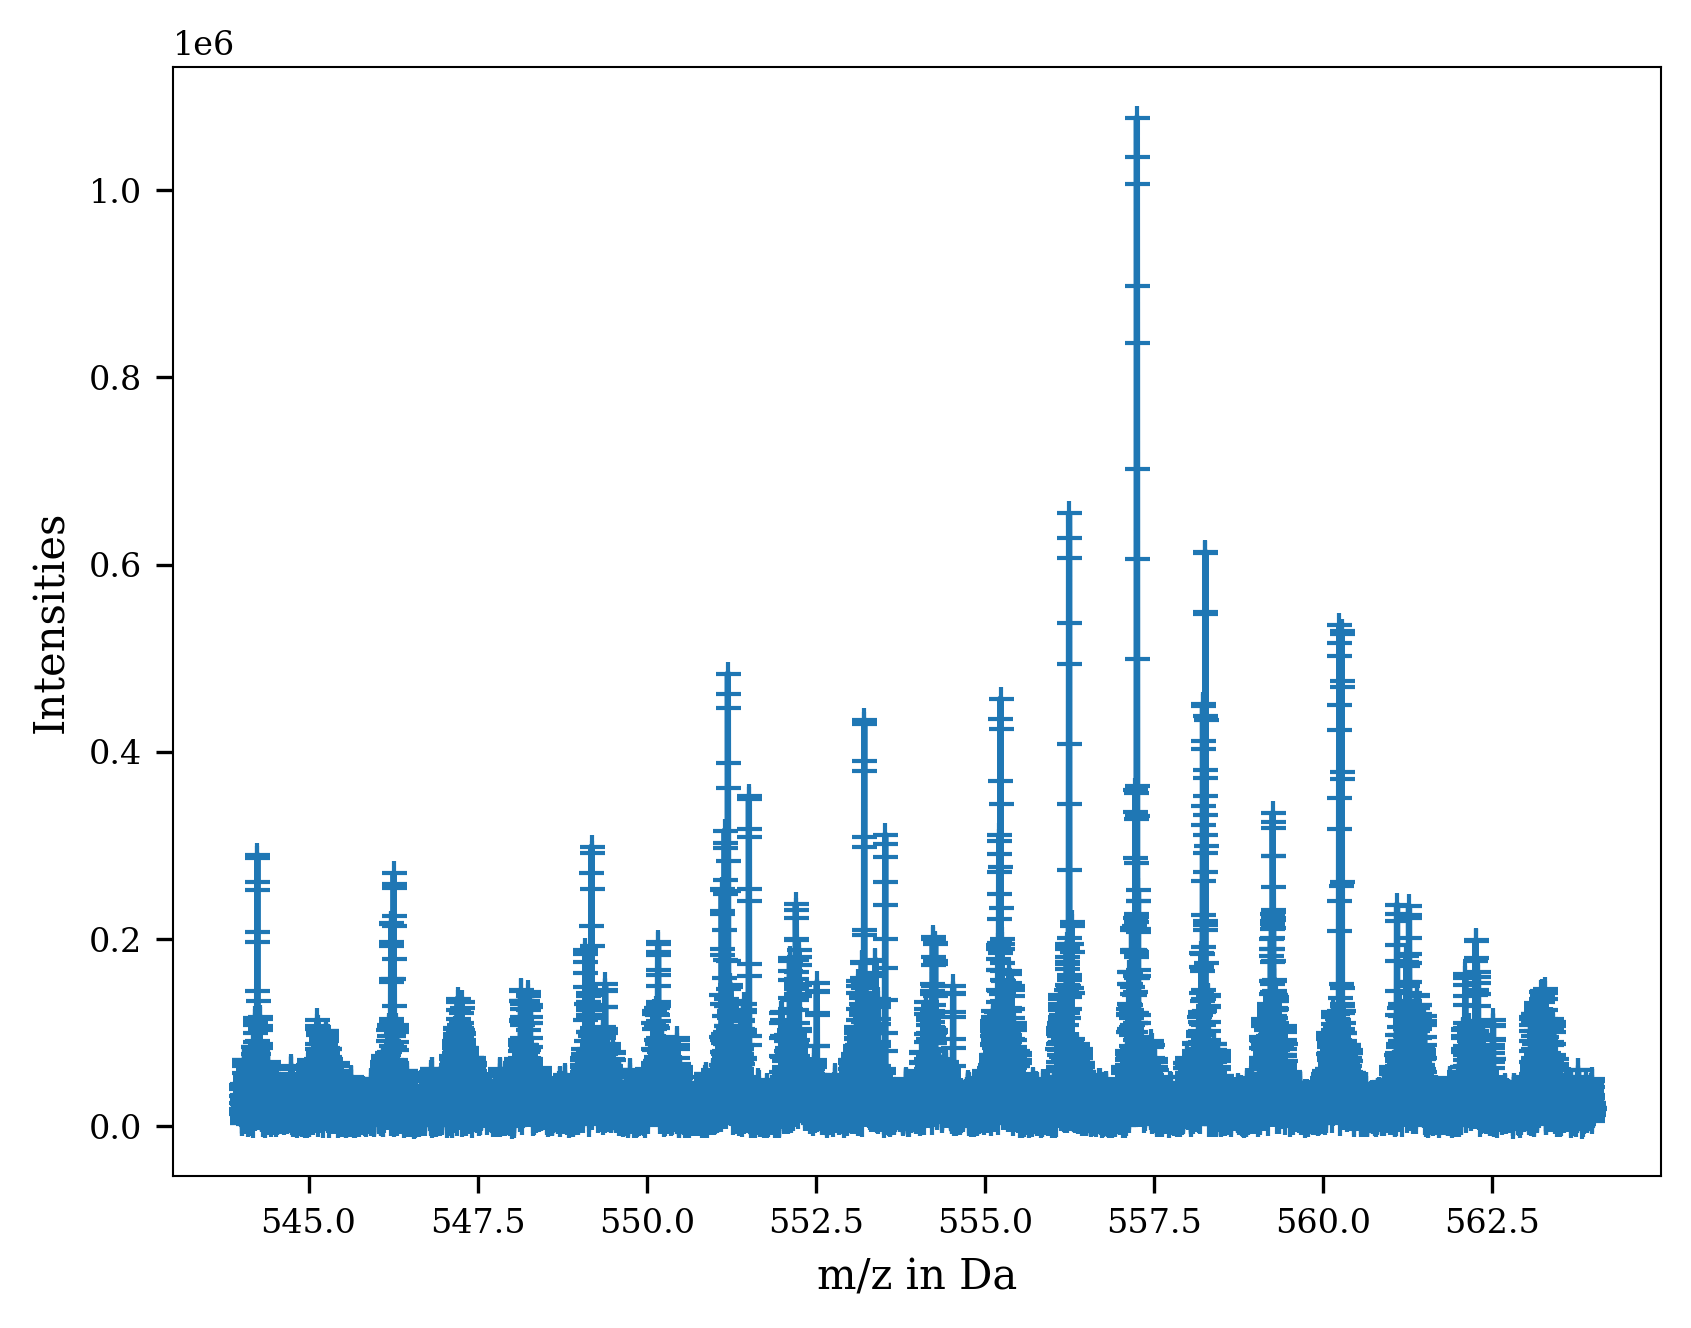

In [5]:
%matplotlib inline
spectrum = reader.get_spectrum(5)  # the 5th spectrum is more interesting than the first few
# let's plot the spectrum
spectrum.plot()

### Create the hdf5 file

In [6]:
# initialize the hdf5 object
# Spectra.hdf5 is the name assumed by downstream functions ... again, this is awkward, but will be 
# replaced by more elegant functions below
hdf5_file = os.path.join(path_d_folder, 'Spectra.hdf5')
hdf = hdf5Handler(hdf5_file)  
hdf.write(reader)  # write the disk file using the ReadBrukerMCF instance to decode the mcf file

Writing to hdf5: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 14.12it/s]


After writing the hdf5 file, initializing a hdf5Handler instance is as simple as 

In [7]:
hdf =  hdf5Handler(hdf5_file)

and of course we can fetch spectra as well

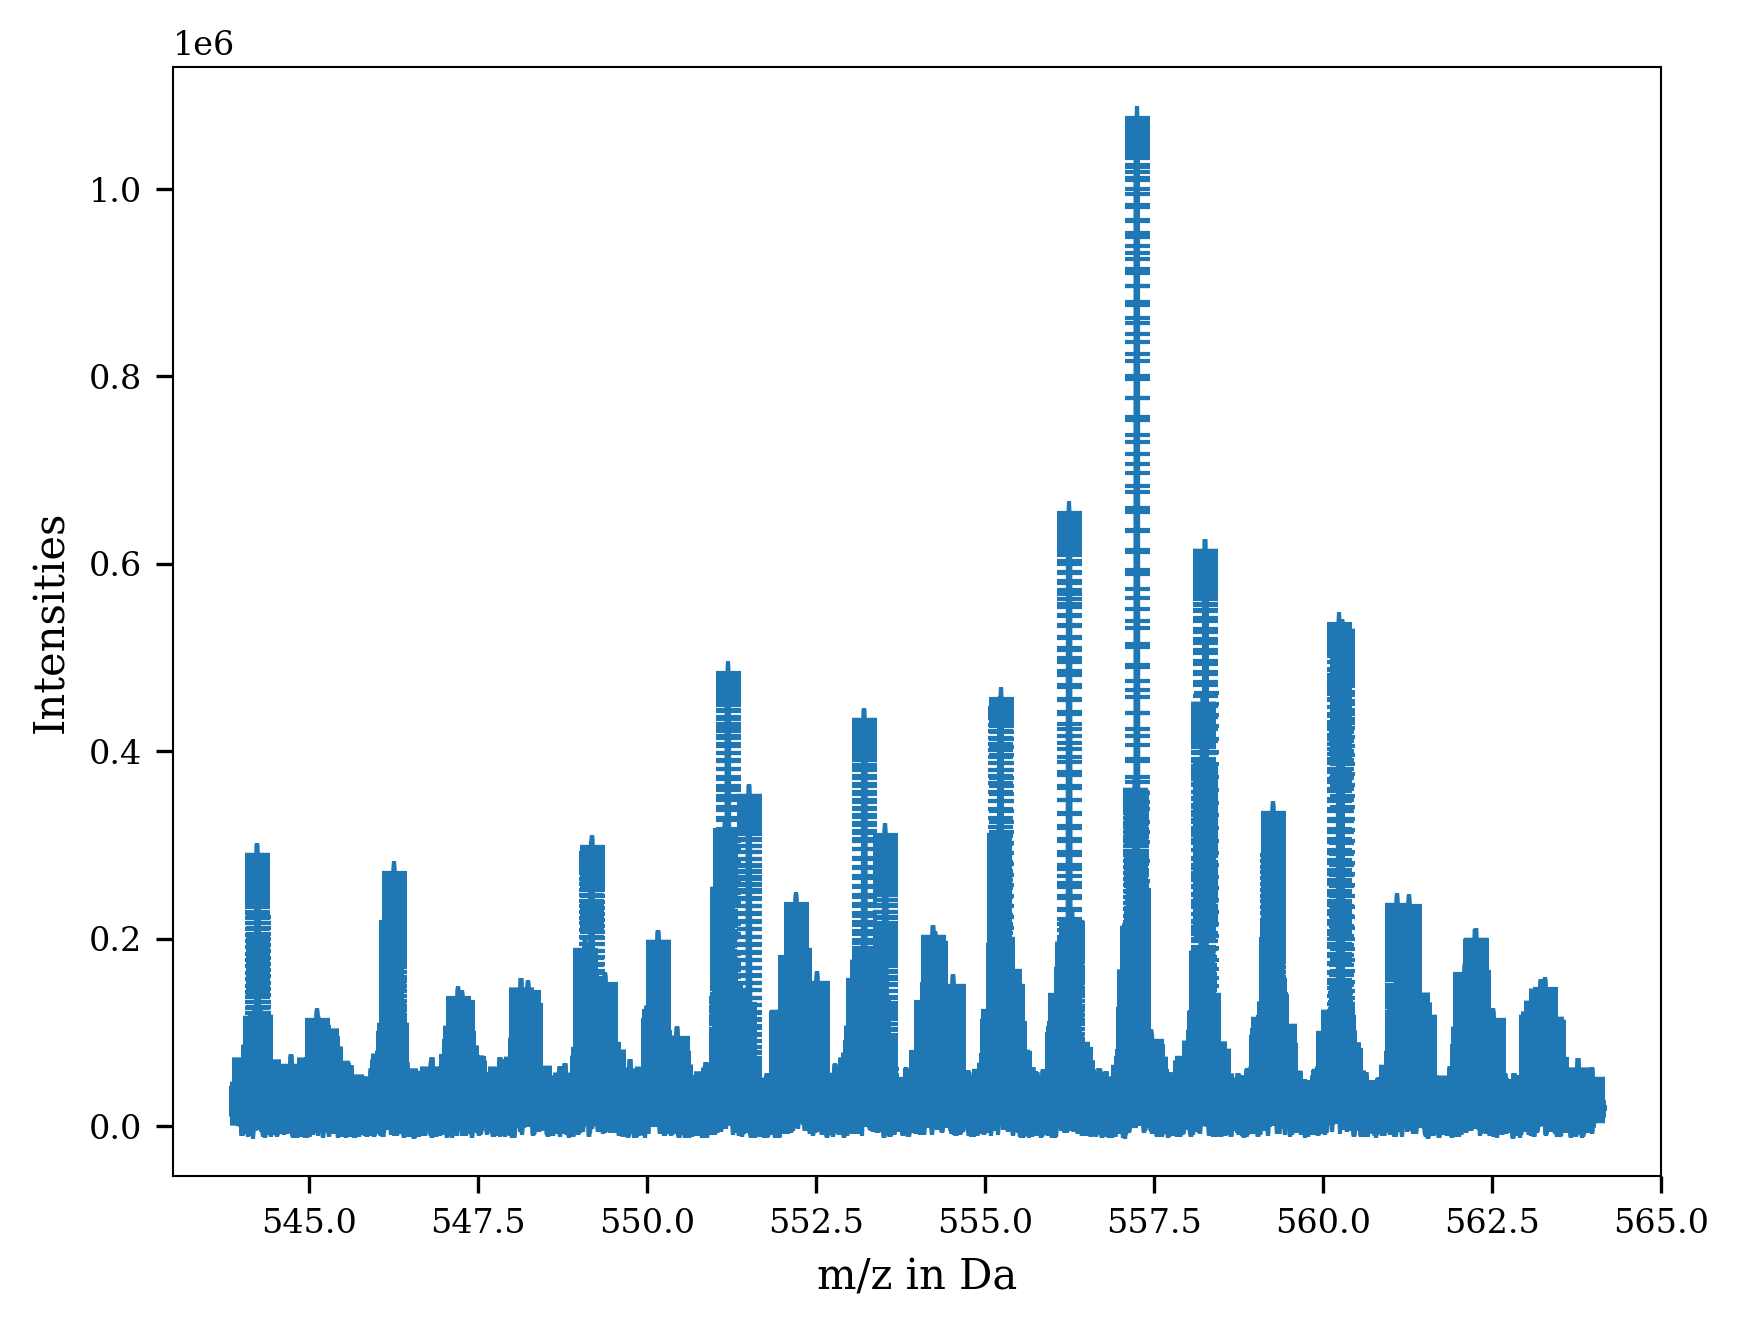

In [8]:
# you can plug in numbers between 1 and 72, because the measurement contains 72 spectra
# since we are accessing a numpy-like array here smaller values are possible since (this accesses the 
# array from behind), but is discouraged. For the ReadBrukerMCF this raises an error.
spectrum = hdf.get_spectrum(5)  # one of the more interesting spectra
spectrum.plot()

Notice that the measurement points are different for the two readers because the hdf5Handler automatically resamples the unevenly spaced data points along spectra from the mcf files. To make sure we don't lose any information doing this, the spectra are heavily upsampled (spacing of 0.1 mDa by default). This will be discussed in more detail below. 

Also, pay attention to the file size: for this small example measurement we don't have to worry about this, but depending on the mass window size and sampling ratio the hdf5 file may even exceed the size of the mcf files. This is one major downside of this approach, which is why you may want to consider skipping writing hdf5 files at the expense of (way) longer processing times if you are running low on disk space. As a rule of thumb, you need $N \cdot m_\text{span} / \Delta m \cdot 8 / 1024^3$ GB (plus some overhead), where $N$ is the number of spectra and $m_\text{span}$ the mass window size and $\Delta m$ the sampling interval.

Doing this calculation for our example with 
* $N = 72$
* $m_\text{span} = (564 - 544)\,\text{Da} = 20\,\text{Da}$
* $\Delta m = 0.1\,\text{Da}$

we get 110 MB, which is slightly less than the actual value of 111 MB due to the overhead.

## Using the ProjectMSI class
Now let's look at the more comfortable way of using the `ProjectMSI` class. We recommend using the `get_project` function to get an instance. This function can also be used to get `ProjectXRF` instances (which we will explore in a different notebook, they are used to process micro-XRF data)

In [9]:
from maspim import get_project

In [10]:
# the same function can be used to get an XRF project by setting is_MSI to False
# notice that we only need to require the folder with the measurement
project = get_project(is_MSI=True, path_folder=path_folder)

We can check that `project` is actually a `ProjectMSI` instance

In [11]:
type(project)

maspim.project.main.ProjectMSI

The `ProjectMSI` class is able to find the right files on its on and initializes the `ReadBrukerMCF` instance automatically.

In [12]:
project.set_hdf_file()

creating BrukerMCF reader, this may take a while ...
Writing to hdf5: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 14.60it/s]


### require methods
It is even better to use `require` methods, which are available in this case and for many other steps as well which act in the following way:
If the requested object exists as a savestate on disk, it will be loaded and returned. If it does not exist yet, it will be initialized upon the method call with the default parameters (or those provided), create a savestate, and then return the instance. 

Overall, this method ensures that we obtain the requested object, whether it already exists or not.

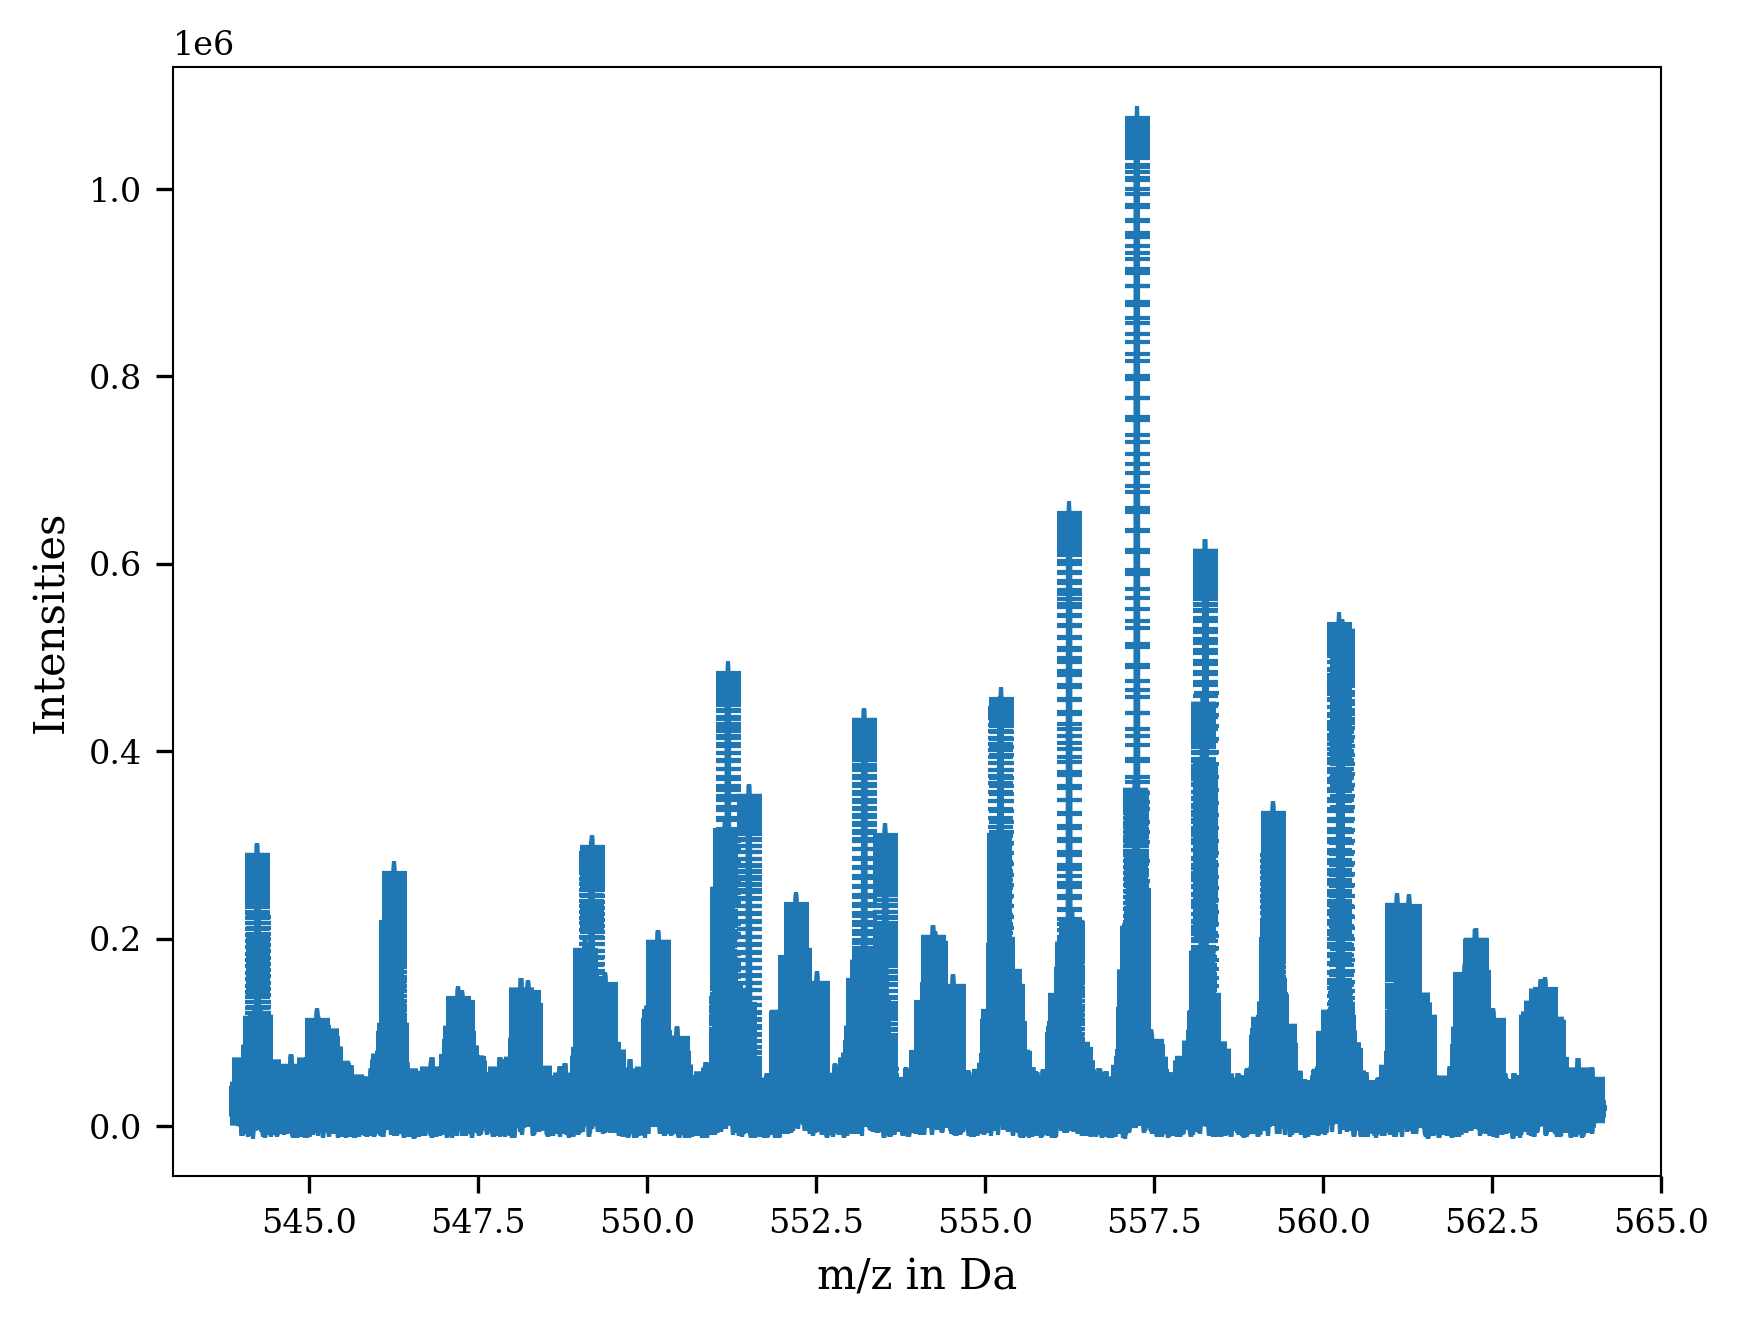

In [13]:
reader = project.require_hdf_reader()
reader.get_spectrum(5).plot()

If you want to avoid using hdf5 files, you can request an `ReadBrukerMCF` instance like this:

creating BrukerMCF reader, this may take a while ...


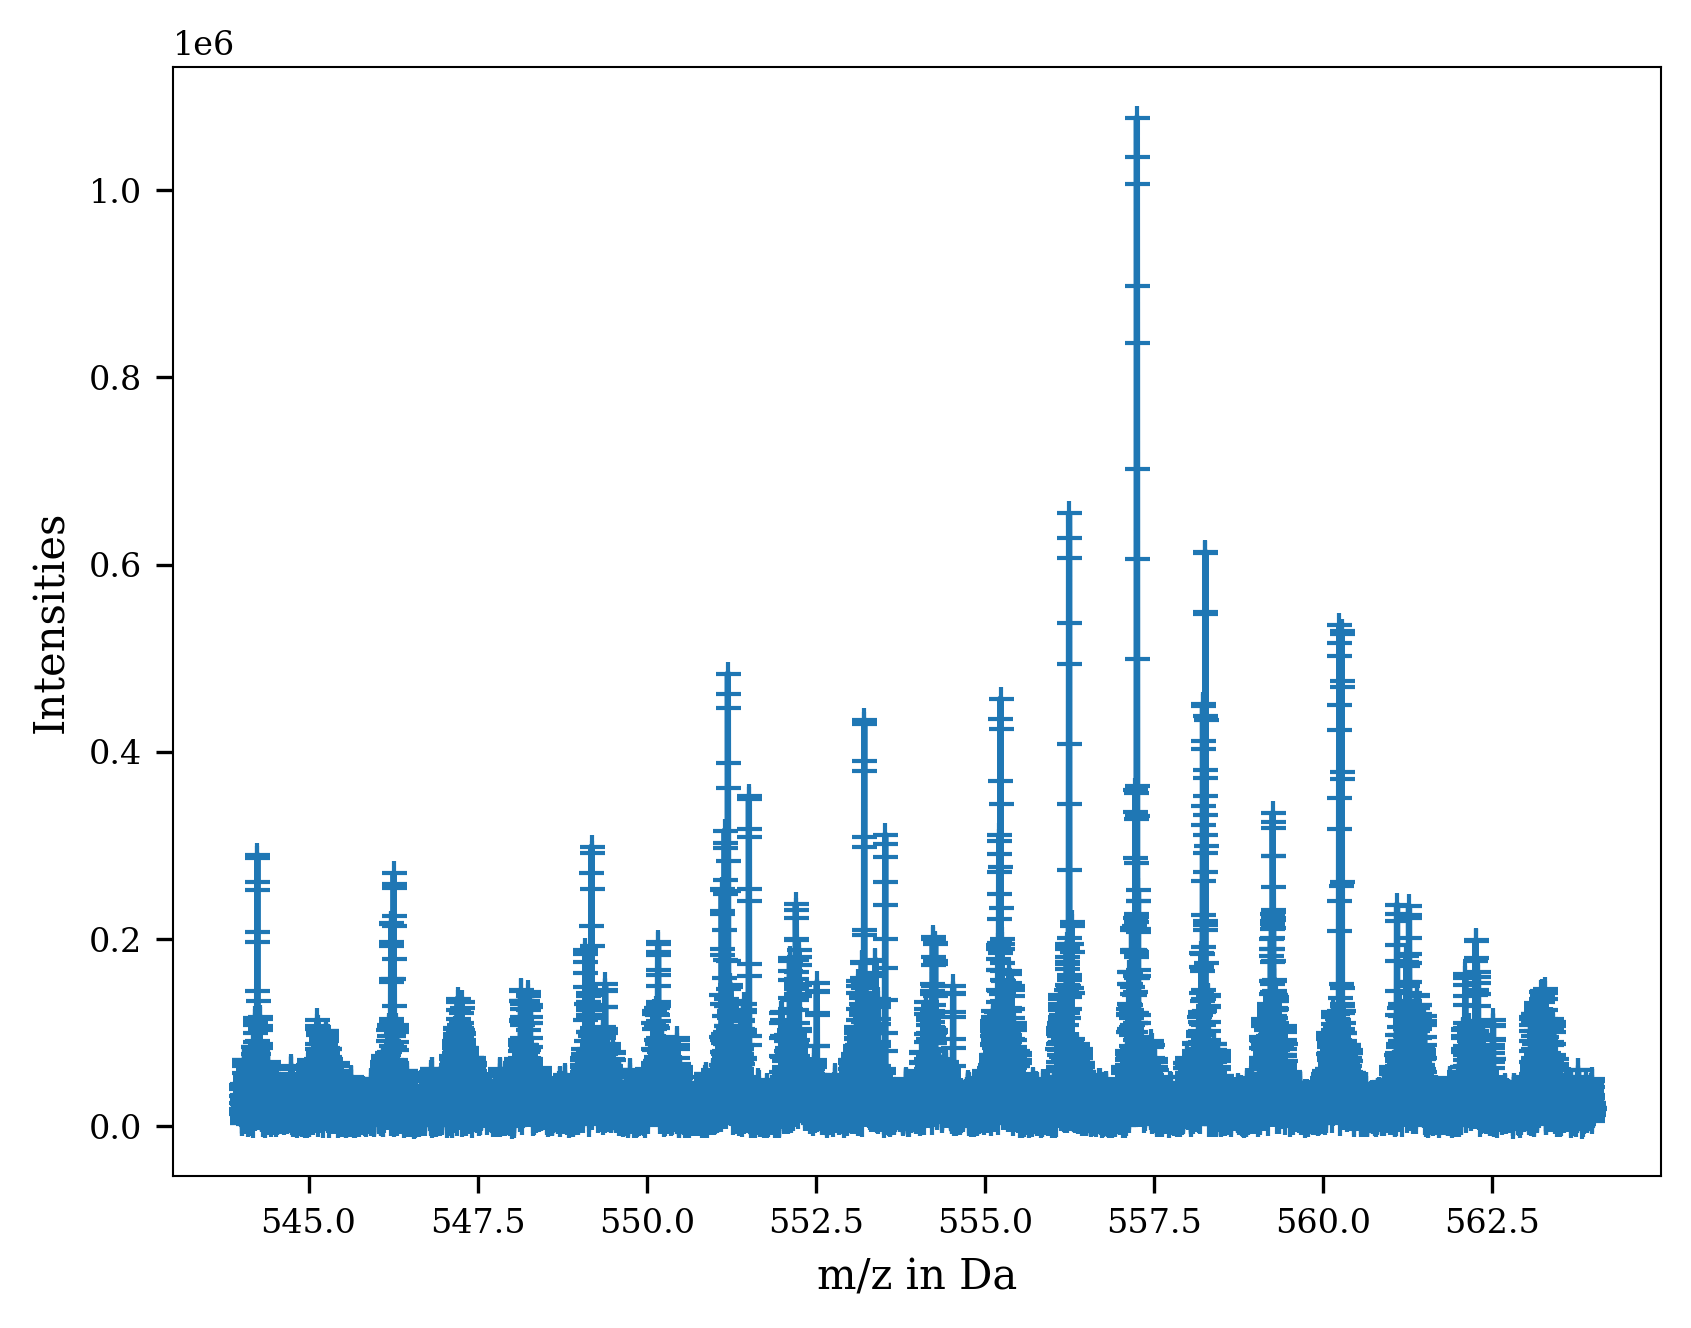

In [14]:
reader = project.get_mcf_reader()
reader.get_spectrum(5).plot()

## Choosing parameters
As mentioned above, the sampling interval has a big impact on the file size and also impacts downstream performance slightly. Therefore, it is worthwhile investigating if the sampling interval can be increased without much loss of information. Here we compare two sampling intervals and see some signal loss for the larger value. We encourage you to play around with the values to investigate at which point the deviations are noticeable. 

Let's first initialize the project (this time we only need a single spectrum and we want to take it from the `ReadBrukerMCF` instance (where it was not resampled)

In [15]:
from maspim import get_project

project = get_project(is_MSI=True, path_folder=path_folder)
mcf_reader = project.get_mcf_reader()
# try different resample values
delta_mzs = [1e-4, 1e-3]

creating BrukerMCF reader, this may take a while ...


Now resample the spectrum with different sample intervals

In [16]:
resampled = {'original': mcf_reader.get_spectrum(5)}
for dmz in delta_mzs:
    spectrum = mcf_reader.get_spectrum(5)
    spectrum.resample(delta_mz=dmz)
    resampled[dmz] = spectrum

and visualize the result

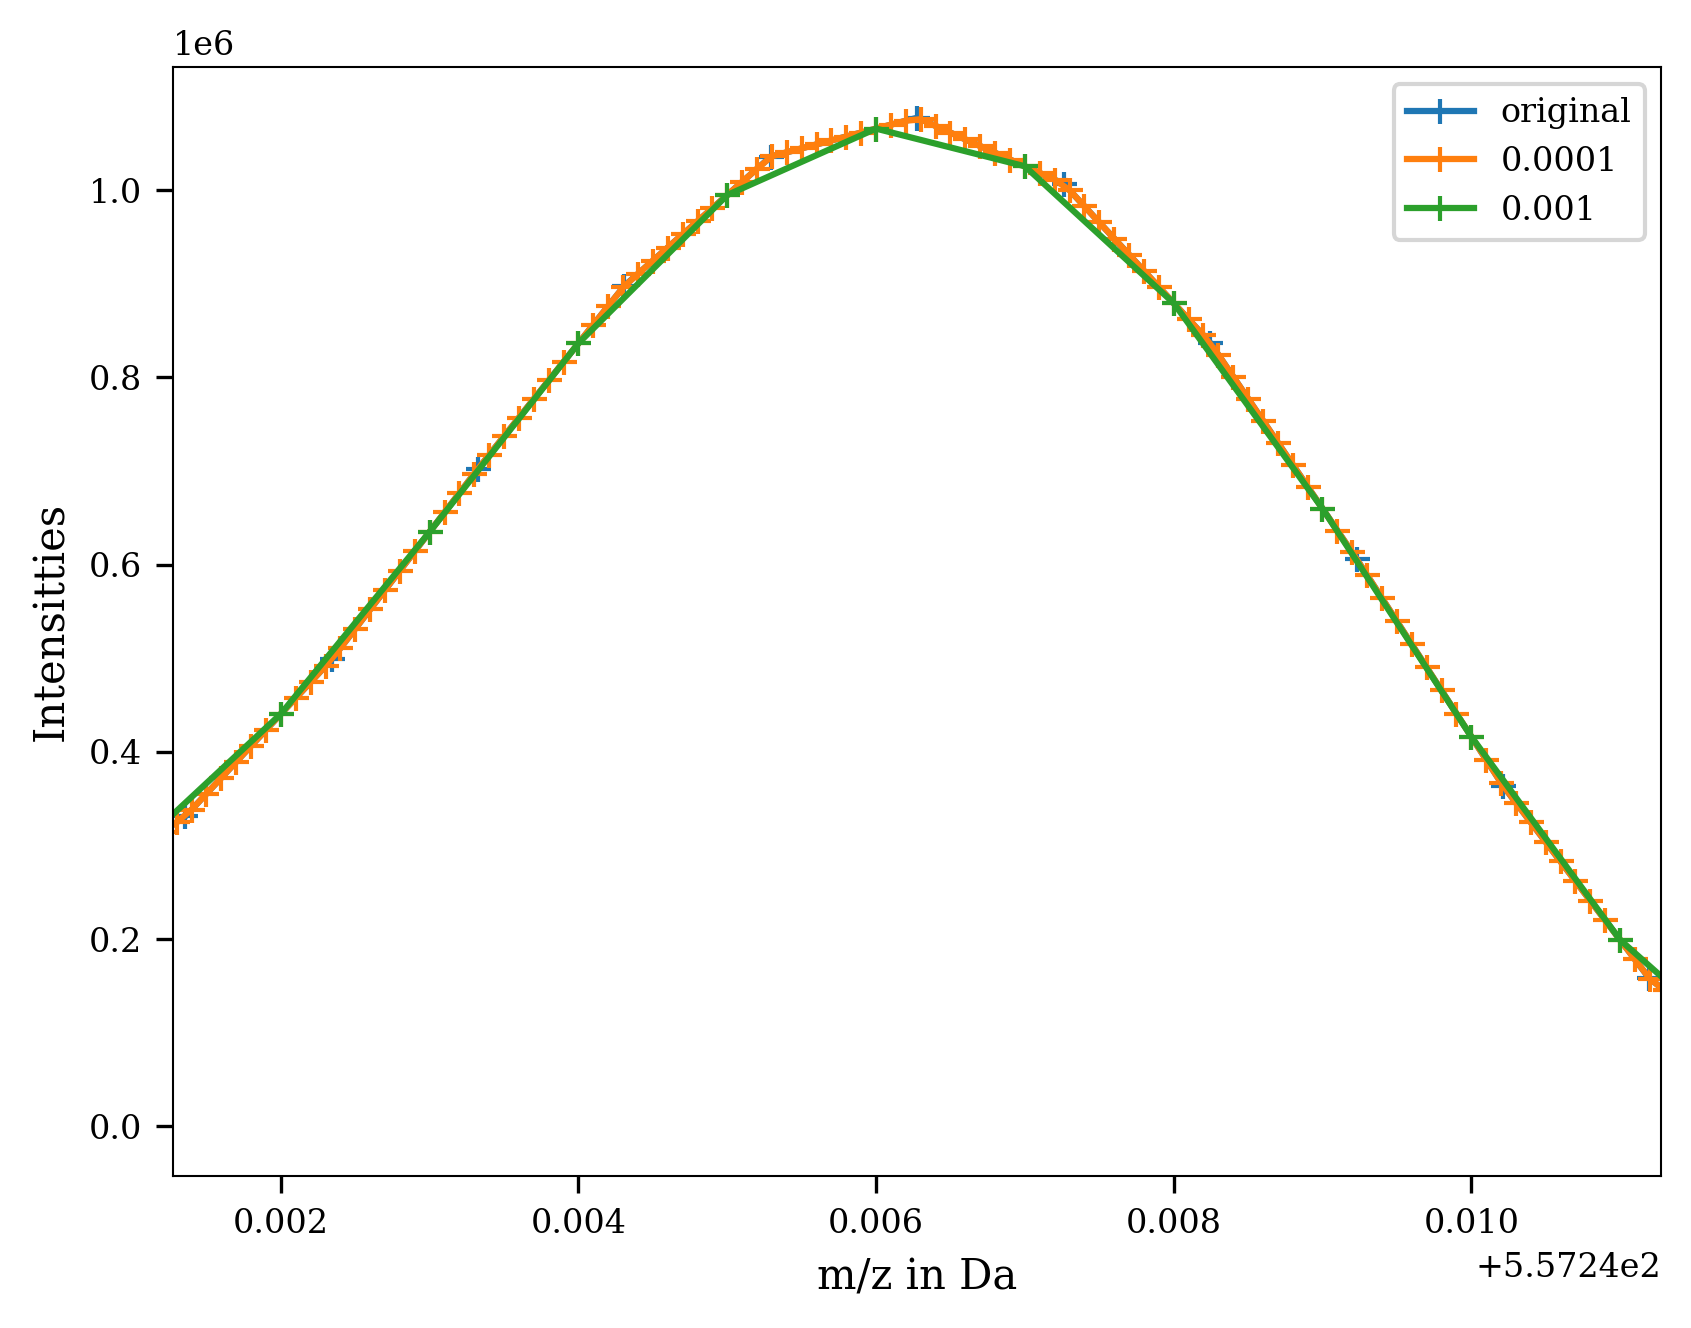

In [17]:
import matplotlib.pyplot as plt
import numpy as np

for k, v in resampled.items():
    plt.plot(v.mzs, v.intensities, '+-', label=k)
plt.legend()
plt.xlabel('m/z in Da')
plt.ylabel('Intensitties')
# window around highest peak
first_spec = list(resampled.values())[0]
peak = first_spec.mzs[np.argmax(first_spec.intensities)]
plt.xlim((peak - .005, peak + .005))  # you want to zoom in on a single peak
plt.show()

We can see that a sampling interval of 1 mDa is not enough to maintain the peak shape. The effect on the general shape of peaks may be negligible, but at this point, you will also lose precision of compounds in the feature table since the set of assignable masses is limited to those in the resampled spectra. Consequently, we'd recommend sticking to values between 0.1 and 1 mDa